# Predict `Glucose`

In [1]:
%matplotlib inline

In [2]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
# from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
# from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time
from pathlib import Path
import math
from sklearn.preprocessing import StandardScaler

In [3]:
%matplotlib inline

In [4]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
phenotype = 'WBC'

In [7]:
#load data
aging_dir = Path('/home/ubuntu/a/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(10e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 10000, 27, 1)
Dimensions of samples: (260, 85)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


count    202.000000
mean       5.601485
std        1.376978
min        2.700000
25%        4.700000
50%        5.450000
75%        6.375000
max       12.500000
Name: WBC, dtype: float64


<AxesSubplot:ylabel='Frequency'>

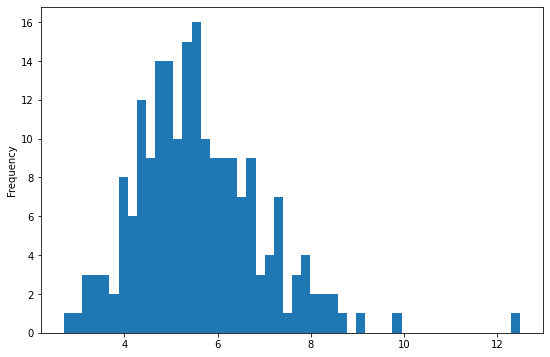

In [8]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist(bins=50)

In [9]:
##### Step 3: split train, validation and test######
x = []
y = []
for i, row in samples.iterrows():
    if math.isnan(row[phenotype]):
        continue
    phenval = row[phenotype]
    x.append(cyto_data[i])
    y.append(phenval)
x = np.asarray(x)
y_raw = np.asarray(y)

x_train, x_valid, y_train, y_valid = train_test_split(x, y_raw)

y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(y_train)
y_train = scaler.transform(y_train).reshape(1,-1)[0]
y_valid = scaler.transform(y_valid).reshape(1,-1)[0]
print(x_train.shape, x_valid.shape)

(151, 10000, 27, 1) (51, 10000, 27, 1)


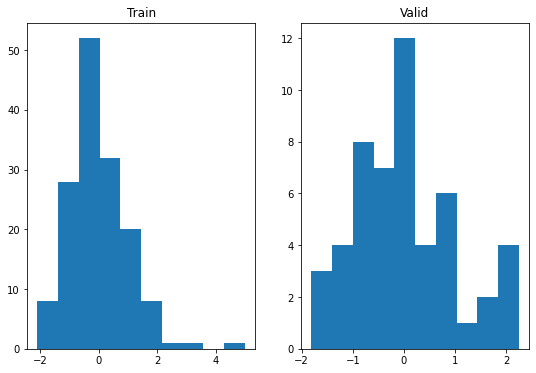

In [10]:
fig, axes = plt.subplots(1,2)
axes[0].hist(y_train, bins=10)
axes[0].set_title('Train')
axes[1].hist(y_valid, bins=10)
axes[1].set_title('Valid')
plt.show()

In [23]:
model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(3, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(6, kernel_size = (1,1), activation=None),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(3, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation=None),
])
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 10000, 1, 3)       84        
_________________________________________________________________
batch_normalization_3 (Batch (None, 10000, 1, 3)       12        
_________________________________________________________________
activation_3 (Activation)    (None, 10000, 1, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10000, 1, 6)       24        
_________________________________________________________________
batch_normalization_4 (Batch (None, 10000, 1, 6)       24        
_________________________________________________________________
activation_4 (Activation)    (None, 10000, 1, 6)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 6)          

In [24]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/200
3/3 [==============================] - 1s 152ms/step - loss: 0.9383 - mean_absolute_error: 0.9383 - val_loss: 0.7772 - val_mean_absolute_error: 0.7772
Epoch 2/200
3/3 [==============================] - 0s 60ms/step - loss: 0.9348 - mean_absolute_error: 0.9348 - val_loss: 0.7731 - val_mean_absolute_error: 0.7731
Epoch 3/200
3/3 [==============================] - 0s 56ms/step - loss: 0.9153 - mean_absolute_error: 0.9153 - val_loss: 0.7712 - val_mean_absolute_error: 0.7712
Epoch 4/200
3/3 [==============================] - 0s 56ms/step - loss: 0.9567 - mean_absolute_error: 0.9567 - val_loss: 0.7691 - val_mean_absolute_error: 0.7691
Epoch 5/200
3/3 [==============================] - 0s 55ms/step - loss: 0.8948 - mean_absolute_error: 0.8948 - val_loss: 0.7683 - val_mean_absolute_error: 0.7683
Epoch 6/200
3/3 [==============================] - 0s 49ms/step - loss: 0.9096 - mean_absolute_error: 0.9096 - val_loss: 0.7681 - val_mean_absolute_error: 0.7681
Epoch 7/200
3/3 [==========

In [25]:
rt

26.43377161026001

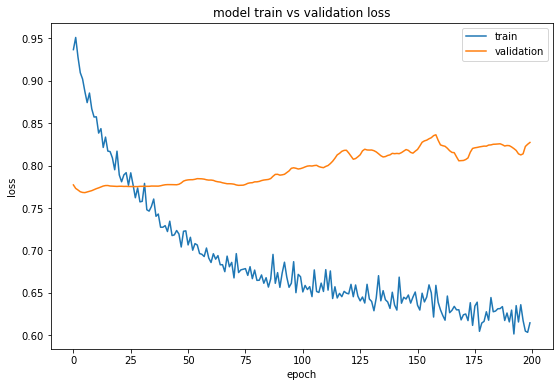

In [26]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
#### Step 7: test the final model #####
final_model = model
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])

In [28]:
vals_true = pd.Series(scaler.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0])
vals_pred = pd.Series(scaler.inverse_transform(y_scores.reshape(-1,1)).reshape(1,-1)[0])

In [29]:
errors = vals_pred - vals_true
errors.describe()

count    51.000000
mean     -0.088899
std       1.512641
min      -5.018039
25%      -1.061999
50%       0.032182
75%       0.793165
max       2.837477
dtype: float64

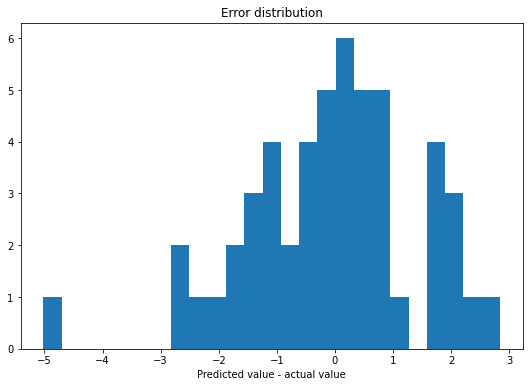

In [30]:
plt.hist(errors, bins=25)
plt.title('Error distribution')
plt.xlabel('Predicted value - actual value')
plt.show()

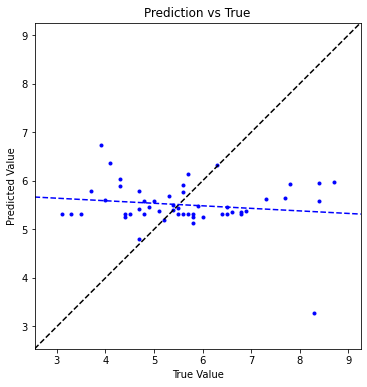

In [31]:
plt.plot(vals_true, vals_pred,'b.')
plt.axis('square')
limits = (min(min(vals_true), min(vals_pred)), max(max(vals_true), max(vals_pred)))
limits = (limits[0] - 0.1*(limits[1] - limits[0]), limits[1] + 0.1*(limits[1] - limits[0]))
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Prediction vs True')
plt.plot(limits,limits,'--k')
coef = np.polyfit(vals_true, vals_pred, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(limits, poly1d_fn(limits), '--b')
plt.show()